# Part I - Ford GoBike System Data Exploration
## by Emmanuel Boluwaji Adeyeye

## Introduction

This dataset contains information about 183,412 rides made in February 2022 in a bike-sharing system covering the greater San Francisco Bay area. The attributes include Trip Duration (seconds), Start Time and Date, End Time and Date, Start Station ID, Start Station Name, Start Station Latitude, Start Station Longitude, End Station ID, End Station Name, End Station Latitude, End Station Longitude, Bike ID, User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual), Member Year of Birth, Member Gender. 

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
print(df.shape)
print(df.dtypes)

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object


In [4]:
df.nunique()

duration_sec                 4752
start_time                 183401
end_time                   183397
start_station_id              329
start_station_name            329
start_station_latitude        334
start_station_longitude       335
end_station_id                329
end_station_name              329
end_station_latitude          335
end_station_longitude         335
bike_id                      4646
user_type                       2
member_birth_year              75
member_gender                   3
bike_share_for_all_trip         2
dtype: int64

In [5]:
# Convert to DateTime datatype
df[['start_time', 'end_time']] = df[['start_time', 'end_time']].apply(lambda x: pd.to_datetime(x))

In [6]:
# Extract new columns
for old_column in ['start_time', 'end_time']:
    df[old_column.split('_')[0] + '_hour'] = df[old_column].dt.hour
    df[old_column.split('_')[0] + '_day'] = df[old_column].dt.day_name()

In [7]:
df.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
start_hour                    0
start_day                     0
end_hour                      0
end_day                       0
dtype: int64

In [8]:
df.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip',
       'start_hour', 'start_day', 'end_hour', 'end_day'],
      dtype='object')

In [9]:
missing_stations = df.loc[df.start_station_id.isnull(), ['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']]
missing_stations.shape

(197, 4)

In [10]:
df.drop(missing_stations.index, axis=0, inplace=True)
df.shape

(183215, 20)

In [11]:
missing_birth_year = df.loc[df.member_gender.isnull(), ['member_birth_year']]
missing_birth_year.shape

(8263, 1)

In [12]:
df.drop(missing_birth_year.index, axis=0, inplace=True)
df.shape

(174952, 20)

In [13]:
from datetime import date

today = date.today()
df['member_age'] = today.year - df.member_birth_year

In [14]:
# Convert ride duration from seconds to minutes
df['duration_min'] = df.duration_sec / 60

In [15]:
# Drop irrelevant columns
df.drop(['duration_sec', 'start_time', 'end_time', 'start_station_latitude',
         'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 
         'end_day', 'member_birth_year', 'bike_share_for_all_trip', 
         'start_station_name', 'end_station_name', 'end_hour'],
        axis=1, inplace=True)

In [16]:
df.columns

Index(['start_station_id', 'end_station_id', 'bike_id', 'user_type',
       'member_gender', 'start_hour', 'start_day', 'member_age',
       'duration_min'],
      dtype='object')

### What is the structure of your dataset?

The dataset contains 174,952 records with nine features: 3 features are numeric, and 7 features are categorical. The features are as follows:

Numeric Features

Discrete
- start_hour
- member_age

Continuous
- duration_min

Categorical Features

Nominal
- start_station_id
- end_station_id
- bike_id
- user_type
- member_gender

Ordinal
- start_day

### What is/are the main feature(s) of interest in your dataset?

I am most interested in figuring out what features have the most effect on the average ride duration.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect the user type to have the strongest effect on the average ride duration. I also believe that the time of the day, day of the week, age, and gender of the riders will also have an effect on the average ride duration.

## Univariate Exploration

I will start by looking at the distribution of duration_min (length of each ride in minutes).

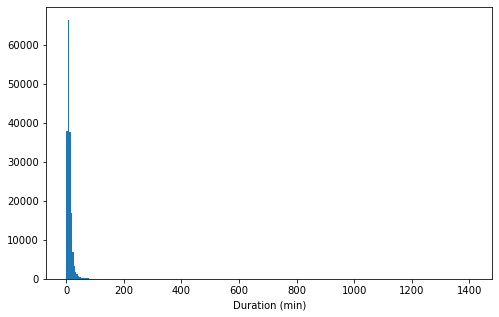

In [17]:
# start with a standard-scaled plot
binsize = 5
bins = np.arange(0, df['duration_min'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xlabel('Duration (min)')
plt.show()

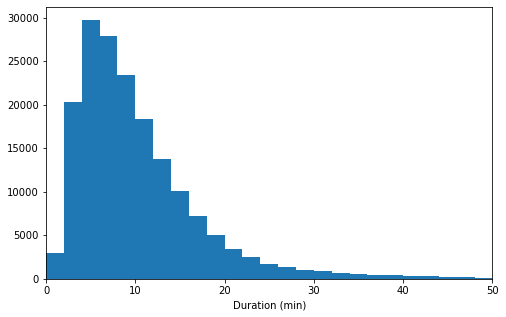

In [18]:
# Investigating further on a smaller x axis limit
binsize = 2
bins = np.arange(0, df['duration_min'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xlabel('Duration (min)')
plt.xlim([0, 50])
plt.show()

The initial plot of the ride duration shows some immediate points of attention. Most of the data is set to the far left of its axis, suggesting some strong outliers on the right. I would explore the feature further in a box plot to identify these outliers and see if I  need to filter them out of the data.

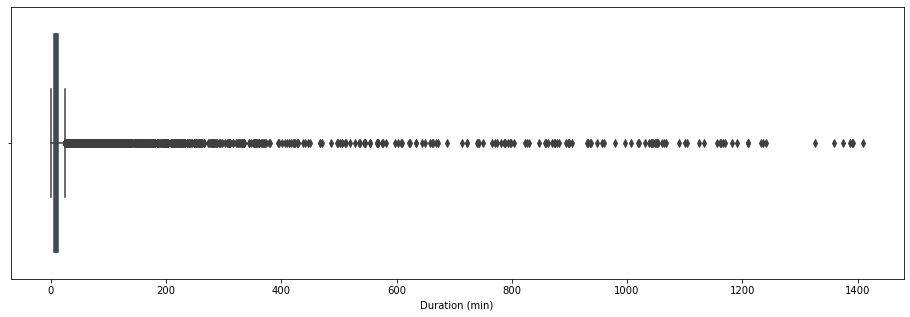

In [19]:
# Investigating further on a box plot
plt.figure(figsize=[16, 5])
sb.boxplot(data = df, x = 'duration_min')
plt.xlabel('Duration (min)')
plt.show()

I have decided to remove all values above 450 in the ride_duration column.

In [20]:
duration_outliers = df.query('duration_min > 450')

In [21]:
df.drop(duration_outliers.index, axis=0, inplace=True)

In [22]:
df.duration_min.describe()

count    174821.000000
mean         11.111522
std          13.582600
min           1.016667
25%           5.383333
50%           8.500000
75%          13.133333
max         449.800000
Name: duration_min, dtype: float64

In [23]:
np.log10(df.duration_min.describe())

count    5.242594
mean     1.045774
std      1.132983
min      0.007179
25%      0.731051
50%      0.929419
75%      1.118375
max      2.653019
Name: duration_min, dtype: float64

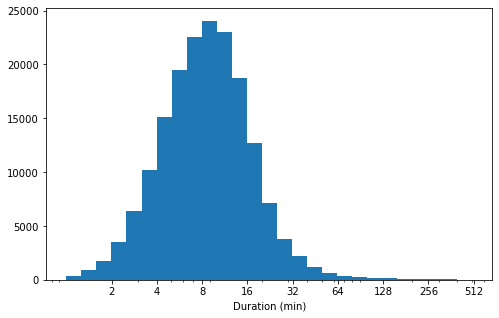

In [24]:
# There's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.1
bins = 10 ** np.arange(0, np.log10(df['duration_min'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xscale('log')
plt.xticks([2, 4, 8, 16, 32, 64, 128, 256, 512], ['2', '4', '8', '16', '32', '64', '128', '256', '512'])
plt.xlabel('Duration (min)')
plt.show()

Ride duration has a long-tailed distribution, with most of the rides on the low duration end, and few on the high duration end. When plotted on a log scale, the ride duration distribution becomes normal and unimodal, with the peak around 8 - 16.

Next up is user_type and member_gender.

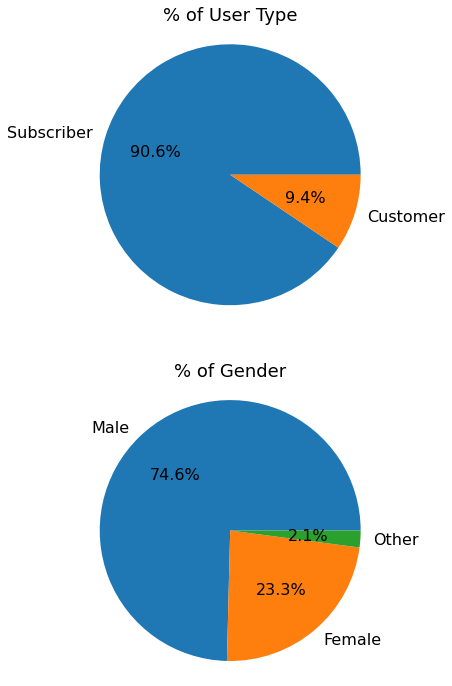

In [25]:
# Plot a pie chart
fig, ax = plt.subplots(nrows=2, figsize = [8,12])
ax[0].set_title('% of User Type', fontdict={'fontsize': 18})
ax[0].pie(x=df.user_type.value_counts(),
        labels=df.user_type.value_counts().index,
        autopct='%1.1f%%', radius=1.1, 
        textprops={'fontsize': 16}
       )
ax[1].set_title(label='% of Gender', fontdict={'fontsize': 18})
ax[1] = plt.pie(x=df.member_gender.value_counts(),
        labels=df.member_gender.value_counts().index,
        autopct='%1.1f%%', radius=1.1, 
        textprops={'fontsize': 16}
       )
plt.show()

Most of the riders are subscribers. Also, for every female rider, there are three male riders.

# Which hour and day of the week are most rides taken?

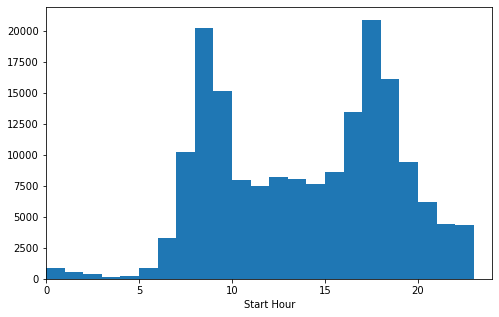

In [26]:
# plotting start_hour on a standard scale
binsize = 1
bins = np.arange(0, df['start_hour'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'start_hour', bins = bins)
plt.xlim([0, 24])
plt.xlabel('Start Hour')
plt.show()

Most of the rides are taken at the hours of 8 and 17, which is expected, since they coincide with rush hours.

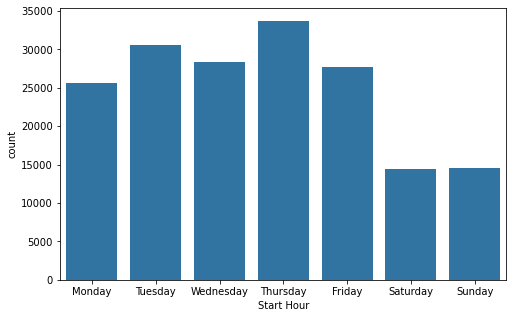

In [27]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = [8, 5])
sb.countplot(data=df, x='start_day', order=weekdays, color=sb.color_palette()[0])
plt.xlabel('Start Hour')
plt.show()

There is a reduction in the number of rides on weekends since most places of work do not open on weekends.

# Which age group forms the bulk of users of the service?

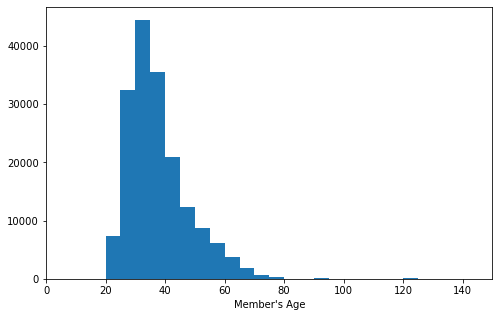

In [28]:
# start with a standard-scaled plot
binsize = 5
bins = np.arange(0, df['member_age'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'member_age', bins = bins)
plt.xlabel("Member's Age")
plt.xlim([0, 150])
plt.show()

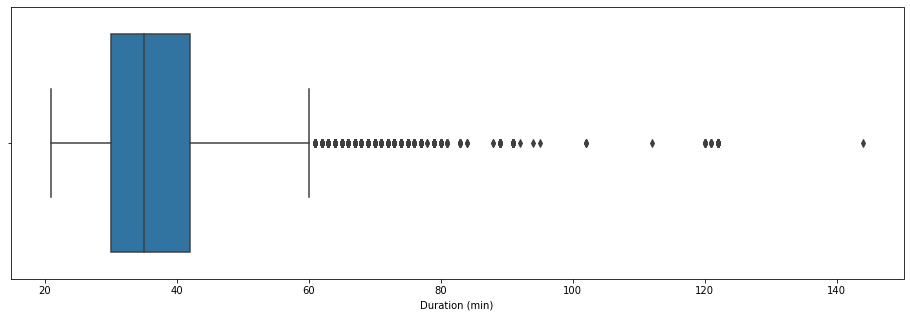

In [29]:
# Investigating further on a boxplot
plt.figure(figsize=[16, 5])
sb.boxplot(data = df, x = 'member_age')
#plt.xticks(log_trans(np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])), 
                     #['2', '4', '8', '16', '32', '64', '128', '256', '512', '1024', '2048'])
plt.xlabel('Duration (min)')
plt.show()

The minimum age is 21. Also, the distribution for the age of the members looks populated on the left-hand side. The plot of the distribution shows that there are outliers. I have decided to remove all values above 85.

In [30]:
age_outliers = df.query('member_age > 85')

In [31]:
df.drop(age_outliers.index, axis=0, inplace=True)

In [32]:
df.member_age.describe()

count    174632.000000
mean         37.127113
std           9.880890
min          21.000000
25%          30.000000
50%          35.000000
75%          42.000000
max          84.000000
Name: member_age, dtype: float64

In [33]:
# Cut the member_age column into bins
df.member_age = pd.cut(df.member_age, bins=[20, 30, 40, 50, 60, 70, 80, 90], labels=
                       ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-85'])

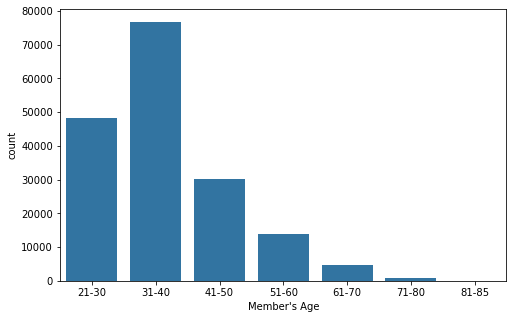

In [34]:
#
plt.figure(figsize=[8, 5])
sb.countplot(data = df, x = 'member_age', color=sb.color_palette()[0])
plt.xlabel("Member's Age")
plt.show()

Users between the ages of 31-40 made more than 40% of the rides. Although there is an increase in the number of rides as the age increases from 21 to 40, the number of rides decreases as the age increases hereon.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The Ride Duration variable took on a wide range of values, so I looked at the data using a log transform. Under the transformation, the data became unimodal, with its peak around 8.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Some outliers were noticed when investigating the Ride Duration and Member Age variables. Overall, these points were noticeable because of their absurd values. For safety, all of these points were removed from the dataset.

## Bivariate Exploration

# What is the effect of the categorical features on the numerical features?

In [35]:
numeric_vars = ['duration_min', 'start_hour']
categorical_vars = ['user_type', 'start_day', 'member_gender', 'member_age']

In [36]:
# compute the logarithm of duration_min to make multivariate plotting easier
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df['log_duration_min'] = df['duration_min'].apply(log_trans)

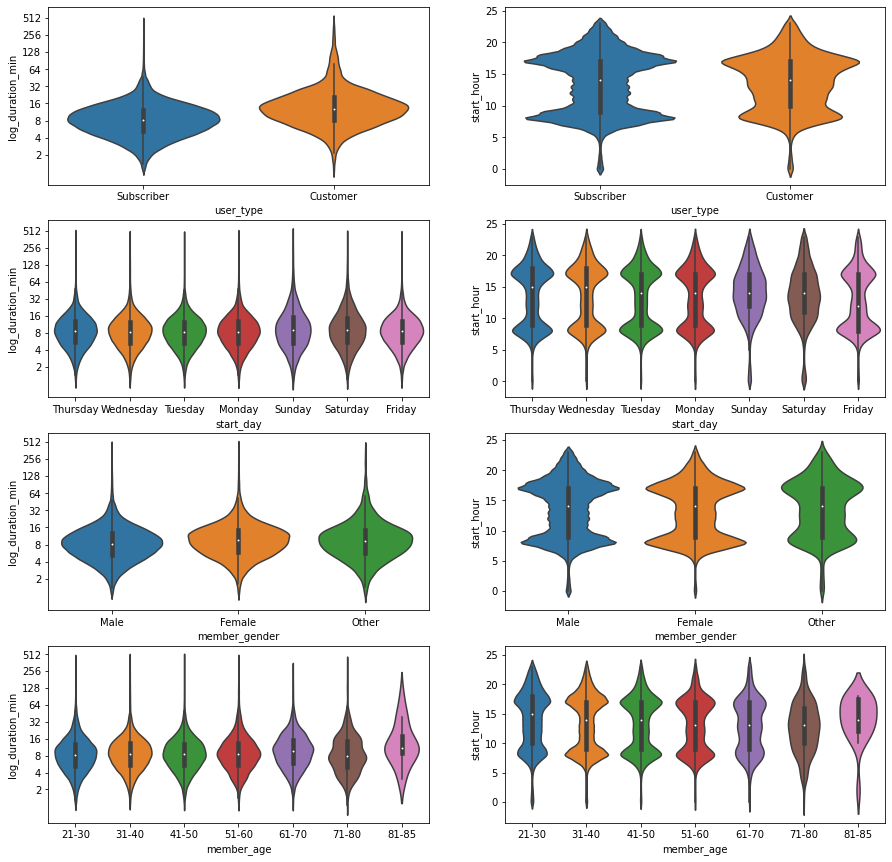

In [37]:
# plot the categorical variables against duration_min and start_hour 
fig, ax = plt.subplots(ncols = 2, nrows = 4, figsize = [15,15])

for i in range(len(categorical_vars)):
    var = categorical_vars[i]
    sb.violinplot(data = df, x = var, y = 'log_duration_min', ax = ax[i,0])
    ax[i,0].set_yticks(log_trans(np.array([2, 4,8, 16, 32, 64, 128, 256, 512])))
    ax[i,0].set_yticklabels([2, 4, 8, 16, 32, 64, 128, 256, 512])
    
    sb.violinplot(data = df, x = var, y = 'start_hour', ax = ax[i,1])
plt.show()

The number of rides by subscribers around 8 and 17 looks almost the same. It shows that most of the people that made the rides around 8 were the ones that used the bike share service around 17. Customers made more rides around 17 than every other hour. The proprtion of the number of rides made during rush hour to that of the other hours decreases on weekends. The proportion also decreases as the age increases form 40 upwards. 

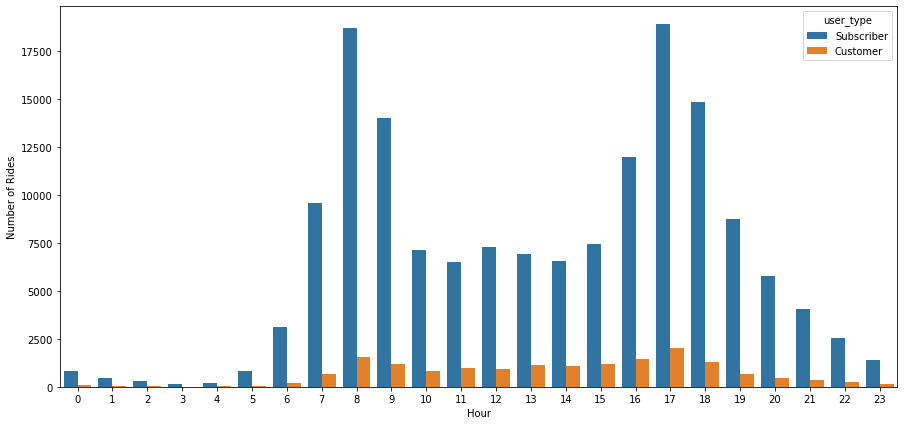

In [38]:
plt.figure(figsize = (15, 7))
sb.countplot(data=df, x='start_hour', hue='user_type', dodge=0.3)
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.show()

The distribution of the number of rides for each user type is similar. Both user types peaked around 8 and 5.

# What is the average ride duration over time?

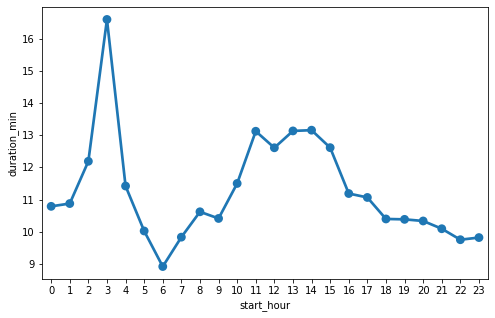

In [39]:
# point plot
plt.figure(figsize = [8, 5])
sb.pointplot(data=df, x='start_hour', y='duration_min', ci=None)
plt.show()

The average ride duration is highest around 3 and lowest around 6.

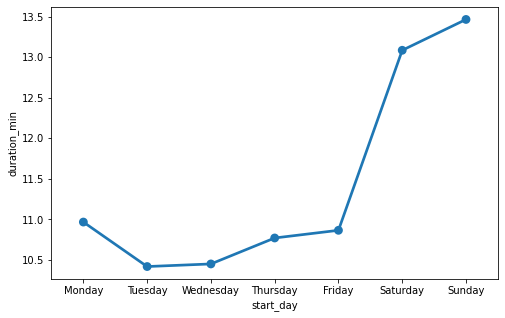

In [40]:
# point plot
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = [8, 5])
sb.pointplot(data=df, x='start_day', y='duration_min', ci=None, order=weekdays)
plt.show()

There is a spike in the average ride duration on weekends.

# Is there interaction between user type and the other categorical features?

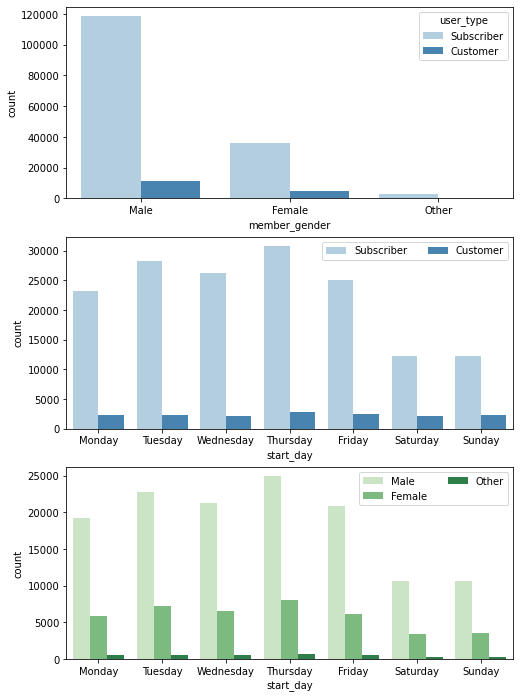

In [41]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = [8, 12])

# subplot 1: member_gender vs user_type
ax = plt.subplot(3, 1, 1)
sb.countplot(data = df, x = 'member_gender', hue = 'user_type', palette = 'Blues')

# subplot 2: start_day vs user_type
ax = plt.subplot(3, 1, 2)
sb.countplot(data = df, x = 'start_day', hue = 'user_type', palette = 'Blues', order=weekdays)
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping

# subplot 3: user_type vs. member_age, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = df, x = 'start_day', hue = 'member_gender', palette = 'Greens', order=weekdays)
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping

plt.show()

There is no interaction between member_gender and the user_type, same as the start_day. Though there is a significant decrease in the number of rides by subscribers on weekends, there is no effect of start_day on customers.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The average ride duration for customers is almost double that of subscribers. It significantly increases over the weekends too. Moreover, the average ride duration is highest around hour 3 and lowest around 6. It shows that most Subscribers use the bike sharing system for work commutes since most trips were made on work days (Mon-Fri) and especially during rush hours (when going to work in the morning and going back home in the afternoon). The average ride duration also slightly increases with age.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

More rides are made during the week than on weekends. During the week, most of the rides are started during rush hours but on weekends, most rides are started in the afternoon. From 21-30 to 31-40, the proportion of the rides made during rush hours to the ones made in the other hours increased. Then, this decreases with increase in age. Riders above 70 mostly start their rides in the afternoon.
 

## Multivariate Exploration

# What is the average ride duration for each user type over time?

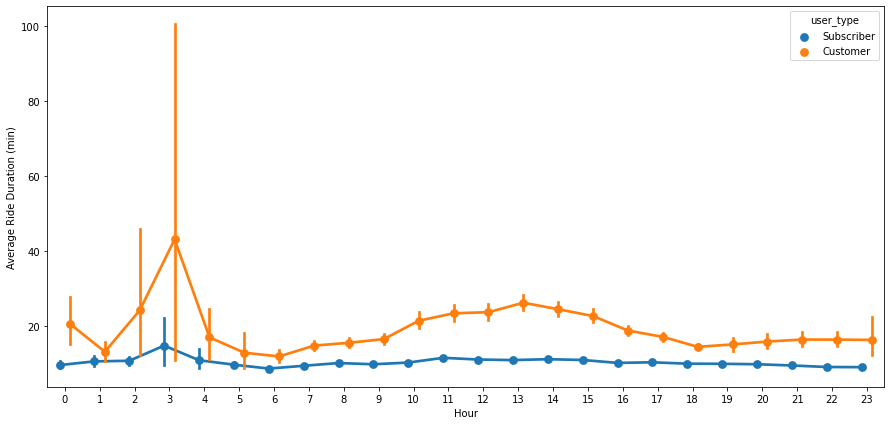

In [42]:
plt.figure(figsize = (15, 7))
sb.pointplot(data=df, x='start_hour', y='duration_min', hue='user_type', dodge=0.3, linestyles="-")
plt.xlabel('Hour');
plt.ylabel('Average Ride Duration (min)')
plt.show()

The average ride duration is highest around 3 for both user types but customers have higher average durations for every hour. For subscribers, the average ride duration rises fom 6 in the morning till 13 and then slopes downwards to 18.

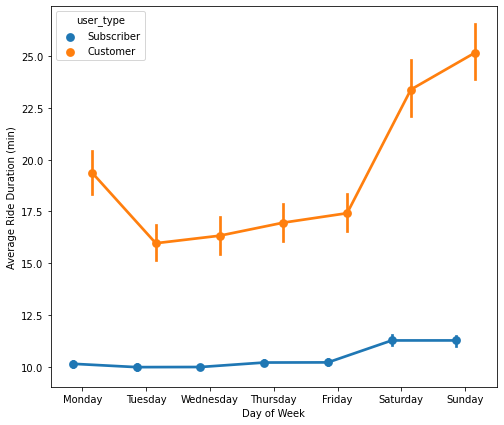

In [43]:
plt.figure(figsize = (8, 7))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.pointplot(data=df, x='start_day', y='duration_min', hue='user_type', dodge=0.3, linestyles="-", order=weekdays)
plt.xlabel('Day of Week');
plt.ylabel('Average Ride Duration (min)');
plt.show()

The average ride duration is highest on weekends for both user types. The increase is higher for customers.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The average duration of rides for both user types depends a lot on the hour and day of the week. The average ride duration for both subscribers and customers is highest at 3 and the spike in the average ride duration for customers on weekends is remarkable compared to that of subscribers.

### Were there any interesting or surprising interactions between features?

Though the number of rides by subscribers is ten times more than that of the customers, the average ride duration by a customer is higher than that of a subscriber.


## Conclusions

The explored dataset originally contained information about 183,412 rides made in February 2022 in a bike-sharing system covering the greater San Francisco Bay area. The attributes include the start and end times of the rides, the year of birth of the user, and the user type. The start and end times variables were converted into DateTime datatypes, and the ride duration which was in seconds was converted to minutes. New variables were also extracted: the hour and the day of the week from the start and end times variables and Member age from the year of the birth variable before being cut into bins. 8780 data points were removed from the analysis due to inconsistencies or missing information. Irrelevant variables were dropped too.

In the exploration, I found out that there is a strong relationship between the user type and the average ride duration, with modifying effects from the start hour and the day of the week the ride was made. Though there are more subscribers than customers, the latter spend more time per ride. The number of rides made on weekends (Saturday and Sunday) by subscribers is significantly lower than that of weekdays whereas customers make almost the same number of rides on weekends as weekdays. However, the average ride duration made on weekends is significantly higher for both user types, with customers having a higher ratio of the average ride duration on a weekend day to that of a weekday.
